In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

ModuleNotFoundError: No module named 'torch'

In [15]:
print(os.listdir("/Users/ak/Documents/GitHub/Lifelong-Learning/MNIST_data"))

FileNotFoundError: [Errno 2] No such file or directory: '../MNIST_data'

In [6]:
# Import Libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

In [7]:
import gzip

In [16]:
# Prepare Dataset
# load data
train = pd.read_csv(r"/Users/ak/Documents/GitHub/Lifelong-Learning/MNIST_data/train.csv",dtype = np.float32)

In [17]:
# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

In [18]:
# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 

In [19]:
# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

In [20]:
# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

In [21]:
# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

In [22]:
# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

In [23]:
# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

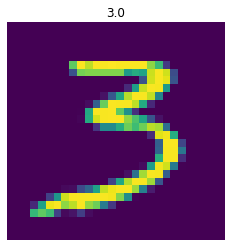

In [24]:
# visualize one of the images in data set
plt.imshow(features_numpy[25].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[25]))
plt.savefig('graph.png')
plt.show()

In [25]:
# 3*3 convolutino
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                    stride=stride, padding=1, bias=False)

In [26]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

In [27]:
def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [28]:
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(1, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[0], 2)
        self.layer3 = self.make_layer(block, 64, layers[1], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [29]:
# batch_size, epoch and iteration
batch_size = 100
n_iters = 2500
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
    
# Create ResNet
net_args = {
    "block": ResidualBlock,
    "layers": [2, 2, 2, 2]
}
model = ResNet(**net_args)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# Adam Optimizer
learning_rate = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [31]:
loss_list = []
iteration_list = []
accuracy_list = []
count = 0

In [37]:
for epoch in range(num_epochs):
    
    for i, (images, labels) in enumerate(train_loader):
        train  = Variable(images.resize_(batch_size, 1, 32, 32))
        labels = Variable(labels)           
        # Clear gradients
        optimizer.zero_grad()    
        # Forward propagation
        outputs = model(train)        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)        
        # Calculating gradients
        loss.backward()        
        # Update parameters
        optimizer.step()        
        count += 1
        
        if count % 250 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            
            for images, labels in test_loader:
                images = Variable(images.resize_(batch_size, 1, 32, 32))                
                # Forward propagation
                outputs = model(images)                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]                
                # Total number of labels
                total += labels.size(0)              
                correct += (predicted == labels).sum()
                accuracy = 100 * correct / float(total)           
                # store loss and iteration
                loss_list.append(loss.data)
                iteration_list.append(count)
                accuracy_list.append(accuracy)
            
        if count % 500 == 0:
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data[0], accuracy))

NotImplementedError: 

In [38]:
a = torch.rand(2, 3)

In [39]:
a

tensor([[0.3866, 0.9422, 0.8497],
        [0.3249, 0.6169, 0.4332]])